# NonLinear Uncertainty Analysis - Monte Carlo

As we've seen, First-Order-Second-Moment (FOSM) is quick and insightful.  But FOSM depends on an assumption that the relation between the model and the forecast uncertainty is linear.  But many times the world is nonlinear. Short cuts like FOSM need assumptions, but we can free ourselves by taking the brute force approach.  That is define the parameters that are important, provide the prior uncertainty, sample those parameters many times, run the model many times, and then summarize the results.  

On a more practical standpoint, the underlying theory for FOSM and why it results in shortcomings can be hard to explain to stakeholders.  Monte Carlo, however, is VERY straightforward, its computational brute force notwithstanding. 

Here's a flowchart from Anderson et al. (2015):

<img src="freyberg_monte_carlo_files/Fig10.14_MC_workflow.png" style="float: center">


## The Current Tutorial

In this notebook we will:
1. Run Monte Carlo on the Freyberg model
2. Look at parameter and forecast uncertainty 
3. Look at the effect of prior parameter uncertainty covariance
4. Start thinking of the advantages and disadvantages of linear and nonlinear uncertainty methods

This notebook is going to be computationaly tough and may tax your computer. So buckle up. 


### Admin

First the usual admin of preparing folders and constructing the model and PEST datasets.

In [1]:
import sys
import os
import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt;

import shutil

sys.path.insert(0,os.path.join("..", "..", "dependencies"))
import pyemu
import flopy
assert "dependencies" in flopy.__file__
assert "dependencies" in pyemu.__file__
sys.path.insert(0,"..")
import herebedragons as hbd

plt.rcParams['font.size'] = 10
pyemu.plot_utils.font =10

In [2]:
# folder containing original model files
org_d = os.path.join('..', '..', 'models', 'monthly_model_files_1lyr_newstress')
# a dir to hold a copy of the org model files
working_dir = os.path.join('freyberg_mf6')
if os.path.exists(working_dir):
    shutil.rmtree(working_dir)
shutil.copytree(org_d,working_dir)
# get executables
hbd.prep_bins(working_dir)
# get dependency folders
hbd.prep_deps(working_dir)
# run our convenience functions to prepare the PEST and model folder
hbd.prep_pest(working_dir)
# convenience function that builds a new control file with pilot point parameters for hk
hbd.add_ppoints(working_dir)

                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                   VERSION 6.3.0 release candidate 07/30/2021
                               ***DEVELOP MODE***

   MODFLOW 6 compiled Dec 29 2021 09:30:50 with Intel(R) Fortran Intel(R) 64
   Compiler for applications running on Intel(R) 64, Version 19.1.3.301 Build
                                20200925_000000

This software is preliminary or provisional and is subject to 
revision. It is being provided to meet the need for timely best 
science. The software has not received final approval by the U.S. 
Geological Survey (USGS). No warranty, expressed or implied, is made 
by the USGS or the U.S. Government as to the functionality of the 
software and related material nor shall the fact of release 
constitute any such warranty. The software is provided on the 
condition that neither the USGS nor the U.S. Government shall be held 
liable for any damages resulting from the autho

took 2.423265 seconds
1 pars dropped from template file freyberg_mf6/freyberg6.npf_k_layer1.txt.tpl
29 pars added from template file ./hkpp.dat.tpl
starting interp point loop for 800 points
took 2.165524 seconds
29 pars added from template file ./rchpp.dat.tpl
noptmax:0, npar_adj:65, nnz_obs:37
new control file: 'freyberg_pp.pst'




Monte Carlo uses lots and lots of forward runs so we don't want to make the mistake of burning the silicon for a PEST control file that is not right.  Here we make doubly sure that the control file has the recharge freed (not "fixed' in the PEST control file).  

### Load the `pst` control file

Let's double check what parameters we have in this version of the model using `pyemu` (you can just look in the PEST control file too.).

We have adjustable parameters that control SFR inflow rates, well pumping rates, hydraulic conductivity and recharge rates. Recall that by setting a parameter as "fixed" we are stating that we know it perfectly (should we though...?). Currently fixed parameters include porosity and future recharge.

For the sake of this tutorial, and as we did in the "sensitivity" tutorials, let's set all the parameters free:

In [3]:
pst_name = "freyberg_pp.pst"
# load the pst
pst = pyemu.Pst(os.path.join(working_dir,pst_name))
#update parameter data
par = pst.parameter_data
#update paramter transform
par.loc[:, 'partrans'] = 'log'

In [4]:
# check if the model runs
pst.control_data.noptmax=0
# rewrite the control file
pst.write(os.path.join(working_dir,pst_name))
# run the model once
pyemu.os_utils.run('pestpp-glm freyberg_pp.pst', cwd=working_dir)

noptmax:0, npar_adj:68, nnz_obs:37


             pestpp-glm: a tool for GLM parameter estimation and FOSM uncertainty analysis

                                   by The PEST++ Development Team


version: 5.1.17
binary compiled on Jun 10 2022 at 13:10:45

started at 08/26/22 11:16:05
...processing command line: ' ./pestpp-glm freyberg_pp.pst'
...using serial run manager

using control file: "freyberg_pp.pst"

in directory: "/Users/mnfienen/Documents/GIT/GMDSI_notebooks/tutorials/part1_12_monte_carlo/freyberg_mf6"
on host: "IGSARMEWLTMNFI"

processing control file freyberg_pp.pst

Note: 'NOPTMAX' == 0, switching to forgiveness mode when checking inputs

Note: 3 unused lines in pest control file, see rec file...
noptmax = 0, resetting max_run_fail = 1
checking model IO files...done
              starting serial run manager ...






    ---  starting serial run manager for 1 runs ---    


08/26/22 11:16:05 processing template files with 1 threads...
thread 0 processed 16 template files

Reload the control file:

In [5]:
pst = pyemu.Pst(os.path.join(working_dir,'freyberg_pp.pst'))
pst.phi

231.23374678631293

# Monte Carlo

In it's simplest form, Monte Carlo boils down to: 1) "draw" many random samples of parameters from the prior probability distribution, 2) run the model, 3) look at the results.

So how do we "draw", or sample, parameters? (Think "draw" as in "drawing a card from a deck"). We need to randomly sample parameter values from a range. This range is defined by the _prior parameter probability distribution_. As we did for FOSM, let's assume that the bounds in the parameter data section define the range of a Gaussian (or normal) distribution, and that the intial values define the mean. 

### The Prior

We can use `pyemu` to sample parameter values from such a distribution. First, construct a covariance matrix from the parameter data in the `pst` control file:

In [6]:
prior_cov = pyemu.Cov.from_parameter_data(pst)

What did we do there? We generated a covariance matrix from the parameter bound values. The next cell displays an image of the matrix. As you can see, all off-diagonal values are zero. Therefore no parameter correaltion is accounted for. 

This covariance matrix is the _prior_ (before history matching) parameter covariance. 

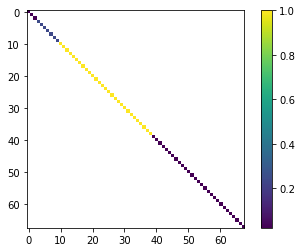

In [7]:
x = prior_cov.as_2d.copy()
x[x==0] = np.nan
plt.imshow(x)
plt.colorbar();

OK, let's now sample 500 parameter sets from the probability distribution described by this covariance matrix and the mean values (e.g. the initial parameter values in the `pst` control file).

In [8]:
parensemble = pyemu.ParameterEnsemble.from_gaussian_draw(pst=pst,cov=prior_cov,num_reals=500,)
# ensure that the samples respect parameter bounds in the pst control file
parensemble.enforce()

Here's an example of the first 5 parameter sets of our 500 created by our draw ("draw" here is like "drawing" a card

In [9]:
parensemble.head()

,ne1,rch0,rch1,strinf,wel0,wel5,wel3,wel1,wel2,wel4,...,rch_i:22_j:12_zone:1.0,rch_i:12_j:17_zone:1.0,rch_i:7_j:17_zone:1.0,rch_i:32_j:12_zone:1.0,rch_i:2_j:7_zone:1.0,rch_i:27_j:2_zone:1.0,rch_i:2_j:17_zone:1.0,rch_i:12_j:12_zone:1.0,rch_i:32_j:2_zone:1.0,rch_i:7_j:7_zone:1.0
0,0.008576,0.798390,1.097442,342.933067,900.000000,95.384015,673.122041,236.651598,93.555705,258.919768,...,1.545899,0.967640,0.765540,0.879551,1.064152,1.094530,1.587063,1.764833,0.699708,0.969906
1,0.007612,1.908030,1.188849,594.907106,88.010442,118.664153,560.794560,900.000000,246.389133,660.090196,...,1.470901,1.380243,1.047585,0.910253,0.688392,0.921585,0.984850,1.211731,0.994265,2.000000
2,0.009936,0.964648,0.670542,566.612120,95.205141,450.603288,468.262566,900.000000,121.221073,198.859473,...,1.504745,1.025225,0.824225,1.357629,1.061188,0.805217,1.426085,1.235177,0.720202,0.742659
3,0.005000,0.862611,1.291555,1949.739433,134.206943,213.220396,900.000000,900.000000,65.534174,900.000000,...,0.641770,1.531370,0.614023,1.068229,0.860114,0.942771,1.791559,1.428844,1.132330,0.736988
4,0.011502,1.170017,0.649204,582.673590,328.172742,56.132756,654.640273,263.797784,886.917946,301.128598,...,1.157887,0.964998,0.950426,0.952610,1.437834,0.899621,1.234873,1.145106,0.844422,0.946133


What does this look like in terms of spatially varying parameters? Let's just plot the hydraulic conductivity from one of these samples. (Note the log-transformed values of K):

   could not remove start_datetime


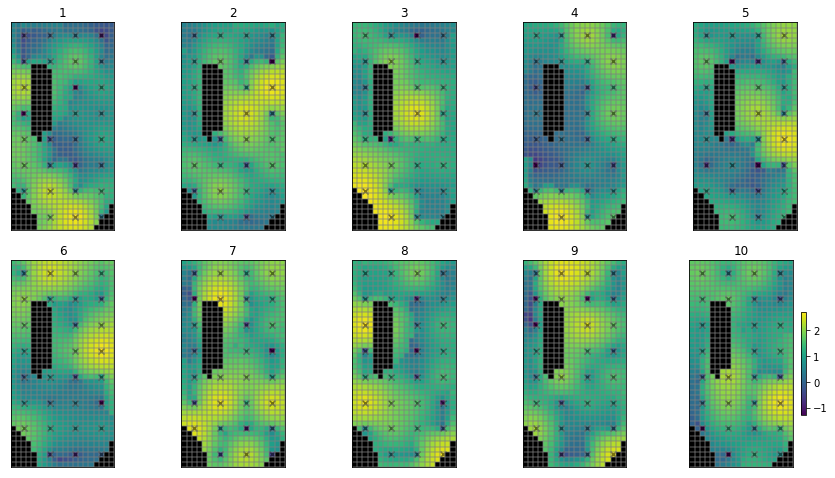

In [10]:
par = pst.parameter_data
parnmes = par.loc[par.pargp=='hk1'].parnme.values
pe_k = parensemble.loc[:,parnmes].copy()

# use the hbd convenienc function to plot several realisations
hbd.plot_ensemble_arr(pe_k, working_dir, 10)

That does not look very realistic. Do these look "right" (from a geologic stand point)? Lots of "random" variation (pilot points spatially near each other can have very different values)...not much structure...why? Because we have not specified any parameter correlation. Each pilot point is statisticaly independent. 

How do we express that in the prior? We need to express parameter spatial covariance with a geostatistical structure. Much the same as we did for regularization. Let's build a covariance matrix for pilot point parameters.

You should be familiar with these by now:


,ne1,rch0,rch1,strinf,wel0,wel5,wel3,wel1,wel2,wel4,...,rch_i:22_j:12_zone:1.0,rch_i:12_j:17_zone:1.0,rch_i:7_j:17_zone:1.0,rch_i:32_j:12_zone:1.0,rch_i:2_j:7_zone:1.0,rch_i:27_j:2_zone:1.0,rch_i:2_j:17_zone:1.0,rch_i:12_j:12_zone:1.0,rch_i:32_j:2_zone:1.0,rch_i:7_j:7_zone:1.0
ne1,0.022655,0.000000,0.000000,0.00,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
rch0,0.000000,0.022655,0.000000,0.00,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
rch1,0.000000,0.000000,0.022655,0.00,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
strinf,0.000000,0.000000,0.000000,0.25,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
wel0,0.000000,0.000000,0.000000,0.00,0.238691,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


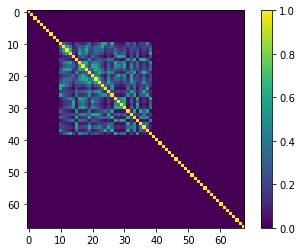

In [11]:
v = pyemu.geostats.ExpVario(contribution=1.0,a=2500,anisotropy=1.0,bearing=0.0)
gs = pyemu.utils.geostats.GeoStruct(variograms=[v])
pp_tpl = os.path.join(working_dir,"hkpp.dat.tpl")
cov = pyemu.helpers.geostatistical_prior_builder(pst=pst, struct_dict={gs:pp_tpl})
# display
plt.imshow(cov.to_pearson().x,interpolation="nearest")
plt.colorbar()
cov.to_dataframe().head()

Now re-sample using the geostatisticaly informed prior:

In [12]:
parensemble = pyemu.ParameterEnsemble.from_gaussian_draw(pst=pst, cov=cov, num_reals=500,)
# ensure that the samples respect parameter bounds in the pst control file
parensemble.enforce()

drawing from group hk1
drawing from group porosity
drawing from group rch0
drawing from group rch1
drawing from group rchpp
drawing from group strinf
drawing from group wel


Here's an example of the first 5 parameter sets of our 500 created by our draw ("draw" here is like "drawing" a card

In [13]:
parensemble.head()

,ne1,rch0,rch1,strinf,wel0,wel5,wel3,wel1,wel2,wel4,...,rch_i:22_j:12_zone:1.0,rch_i:12_j:17_zone:1.0,rch_i:7_j:17_zone:1.0,rch_i:32_j:12_zone:1.0,rch_i:2_j:7_zone:1.0,rch_i:27_j:2_zone:1.0,rch_i:2_j:17_zone:1.0,rch_i:12_j:12_zone:1.0,rch_i:32_j:2_zone:1.0,rch_i:7_j:7_zone:1.0
0,0.009583,0.636000,1.208663,296.866418,109.590198,143.473132,900.000000,347.261007,148.383135,90.848116,...,1.596587,0.958090,0.721037,1.729436,1.744553,0.719409,1.243979,1.195635,0.681879,1.176365
1,0.012451,2.000000,1.358884,401.349422,164.705488,900.000000,386.662038,76.166170,900.000000,69.328231,...,0.603213,0.772045,1.321382,0.859291,0.828841,1.282602,1.006906,0.851859,0.889863,0.998289
2,0.009922,1.966333,1.142492,245.576160,421.100437,110.117281,145.506390,201.207688,510.979844,900.000000,...,0.883169,1.202958,0.728151,0.934369,1.187185,1.646549,1.849163,1.266836,0.941629,0.909086
3,0.007218,0.588905,0.567419,626.098148,71.219612,900.000000,355.428866,227.579461,156.658614,207.097135,...,0.938810,1.209241,1.895610,1.089464,0.638541,1.510416,1.009344,0.525180,1.542154,0.908281
4,0.008293,0.922642,1.029767,476.002182,44.652183,795.533096,21.292506,900.000000,544.941314,826.396753,...,0.832306,1.097875,0.942772,0.916822,0.875572,0.894957,0.539972,0.687725,0.753373,0.994329


Now when we plot the spatialy distributed parameters (`hk1`) we can see some structure and points which are near to each other are morel ikely to be similar:

   could not remove start_datetime


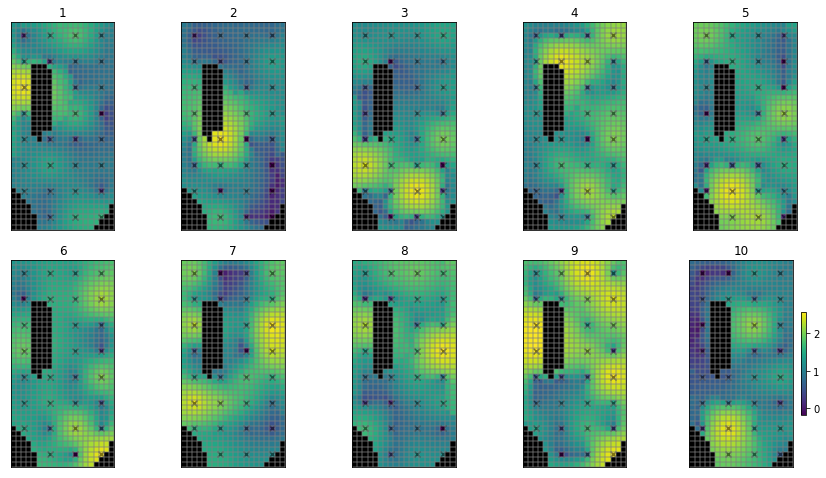

In [14]:
pe_k = parensemble.loc[:,parnmes].copy()
# use the hbd convenienc function to plot several realisations
hbd.plot_ensemble_arr(pe_k, working_dir, 10)

Let's look at some of the distributions. Note that distributions are log-normal, because parameters in the `pst` are log-transformed:

0.005 0.02 0.01067691804894108


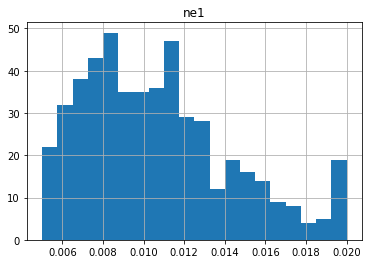

0.5 2.0 1.0730318679538804


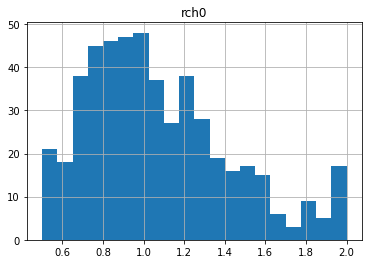

0.5 2.0 1.0685975451074596


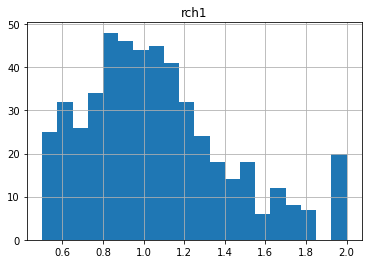

50.0 5000.0 773.0894942537367


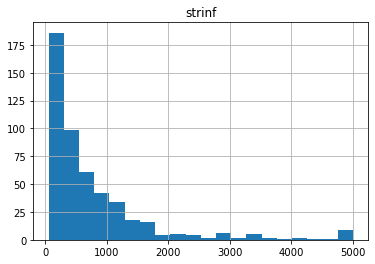

11.121848658985792 900.0 364.8164629415672


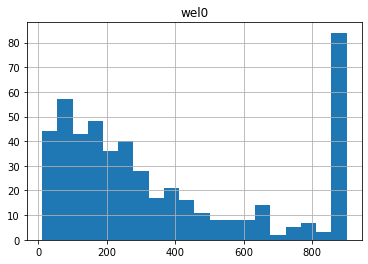

In [15]:
for pname in pst.par_names[:5]:
    ax = parensemble.loc[:,pname].hist(bins=20)
    print(parensemble.loc[:,pname].min(),parensemble.loc[:,pname].max(),parensemble.loc[:,pname].mean())
    ax.set_title(pname)
    plt.show()

Notice anything funny? Compare these distributions to the uper/lower bounds in the `pst.parameter_data`. There seem to be many parameters "bunched up" at the bounds. This is due to the gaussian distribution being truncated at the parameter bounds.

In [16]:
pst.parameter_data.head()

,parnme,partrans,parchglim,parval1,parlbnd,parubnd,pargp,scale,offset,dercom,extra,i,j,zone
parnme,,,,,,,,,,,,,,
ne1,ne1,log,factor,0.01,0.005,0.02,porosity,1.0,0.0,1,NaN,NaN,NaN,NaN
rch0,rch0,log,factor,1.00,0.500,2.00,rch0,1.0,0.0,1,NaN,NaN,NaN,NaN
rch1,rch1,log,factor,1.00,0.500,2.00,rch1,1.0,0.0,1,NaN,NaN,NaN,NaN
strinf,strinf,log,factor,500.00,50.000,5000.00,strinf,1.0,0.0,1,NaN,NaN,NaN,NaN
wel0,wel0,log,factor,300.00,10.000,900.00,wel,-1.0,0.0,1,NaN,NaN,NaN,NaN


### Run Monte Carlo

So we now have 500 different random samples of parameters. Let's run them! This is going to take some time, so let's do it in parallel using [PEST++SWP](https://github.com/usgs/pestpp/blob/master/documentation/pestpp_users_manual.md#10-pestpp-swp).

First write the ensemble to an external CSV file:

In [17]:
parensemble.to_csv(os.path.join(working_dir,"sweep_in.csv"))

As usual, make sure to specify the number of agents to use. This value must be assigned according to the capacity of youmachine:

In [18]:
num_workers = 10

In [19]:
# the master directory
m_d='master_mc'

Run the next cell to call PEST++SWP. It'll take a while.

In [20]:
pyemu.os_utils.start_workers(working_dir, # the folder which contains the "template" PEST dataset
                            'pestpp-swp', #the PEST software version we want to run
                            pst_name, # the control file to use with PEST
                            num_workers=num_workers, #how many agents to deploy
                            worker_root='.', #where to deploy the agent directories; relative to where python is running
                            master_dir=m_d, #the manager directory
                            )



             pestpp-swp - a parameteric sweep utility, version 5.1.17
                     for PEST(++) datasets 

                 by the PEST++ development team


...processing command line: ' ./pestpp-swp freyberg_pp.pst /h :4004'
...using panther run manager in master mode using port 4004



version: 5.1.17
binary compiled on Jun 10 2022 at 13:10:45

started at 08/26/22 11:17:00
using control file: "freyberg_pp.pst"

in directory: "/Users/mnfienen/Documents/GIT/GMDSI_notebooks/tutorials/part1_12_monte_carlo/master_mc"
on host: "IGSARMEWLTMNFI"

processing control file freyberg_pp.pst
Note: 3 unused lines in pest control file, see rec file...
noptmax = 0, resetting max_run_fail = 1
pest++ arg SWEEP_PARAMETER_CSV_FILE not set, using 'SWEEP_IN.CSV'


:~-._                                                 _.-~:
: :.~^o._        ________---------________        _.o^~.:.:
 : ::.`?88booo~~~.::::::::...::::::::::::..~~oood88P'.::.:
 :  ::: `?88P .:::....         ........:::::. ?88P' :::. 

Alright - let's see some MC results.  For these runs, what was the Phi?

In [21]:
df_out = pd.read_csv(os.path.join(m_d,"sweep_out.csv"),index_col=0)
df_out = df_out.loc[df_out.failed_flag==0,:] #drop any failed runs
df_out = df_out.loc[~df_out.le(-2.e27).any(axis=1)] #drop extreme values
df_out.columns = [c.lower() for c in df_out.columns]
df_out.head()

,input_run_id,failed_flag,phi,meas_phi,regul_phi,gage-1,headwater,particle,tailwater,trgw-0-13-10,...,trgw-0-9-1:4108.5,trgw-0-9-1:4138.5,trgw-0-9-1:4169.5,trgw-0-9-1:4199.5,trgw-0-9-1:4230.5,trgw-0-9-1:4261.5,trgw-0-9-1:4291.5,trgw-0-9-1:4322.5,trgw-0-9-1:4352.5,trgw-0-9-1:4383.5
run_id,,,,,,,,,,,,,,,,,,,,,
0,0,0,1197.459966,1197.459966,0.0,1074.617148,0.0,0.0,0.0,0.0,...,38.100665,38.448476,38.743463,38.914525,38.947792,38.853996,38.686739,38.502399,38.381005,38.424153
1,1,0,97121.144746,97121.144746,0.0,1908.275159,0.0,0.0,0.0,0.0,...,104.904499,111.186551,107.555115,94.844038,76.506522,58.812350,46.888685,43.188086,45.810530,59.806389
2,2,0,4124.661534,4124.661534,0.0,1539.485241,0.0,0.0,0.0,0.0,...,47.518769,48.634060,48.131163,46.123209,43.570216,41.911225,41.499874,41.130684,40.869811,40.849156
3,3,0,1313.018853,1313.018853,0.0,1074.244434,0.0,0.0,0.0,0.0,...,35.896787,35.993336,36.065125,36.082378,36.034226,35.928033,35.791431,35.647830,35.538939,35.509485
4,4,0,1478.541711,1478.541711,0.0,878.359499,0.0,0.0,0.0,0.0,...,34.892379,35.083348,35.204861,35.216114,35.110740,34.916072,34.688750,34.474621,34.340063,34.356673


Wow, some are pretty large. What was Phi with the initial parameter values??


In [22]:
pst.phi

231.23374678631293


Let's plot Phi for all 500 runs:

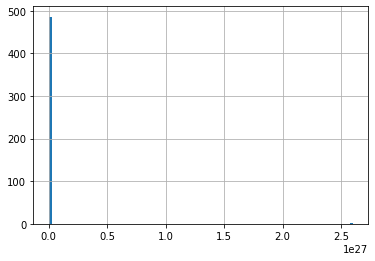

In [23]:
df_out.phi.hist(bins=100);

Wow, some of those models are really REALLY bad fits to the observations.  So, when we only use our prior knowledge to sample the parameters we get a bunch of models with unacceptably Phi, and we can consider them not reasonable.  Therefore, we should NOT include them in our uncertainty analysis.


## Conditioning (a.k.a GLUE)

__IMPORTANT:__  this is super important - in this next block we are "conditioning" our Monte Carlo run by removing the bad runs based on a Phi cutoff. So here is where we choose which realizations we consider __good enough__ with respect to fitting the observation data. 

Those realizations with a phi bigger than our cutoff are out, no matter how close to the cutoff; those that are within the cutoff are all considered equally good regardless of how close to the cutoff they reside.

We started out with a Phi of:

In [24]:
pst.phi

231.23374678631293

Let's say any Phi below 2x `pst.phi` is aceptable (which is pretty poor by the way...):

In [25]:
acceptable_phi = pst.phi * 2
good_enough = df_out.loc[df_out.phi<acceptable_phi].index.values
print("number of good enough realisations:", good_enough.shape[0])

number of good enough realisations: 112


These are the run number of the 500 that met this cutoff.  Sheesh - that's very few!

Here is a __major problem with "rejection sampling" in high dimensions__: you have to run the model many many many many many times to find even a few realizations that fit the data acceptably well.  

With all these parameters, there are so many possible combinations, that very few realizations fit the data very well...we will address this problem later, so for now, let bump our "good enough" threshold to some realizations to plot.

Let's plot just these "good" ones:

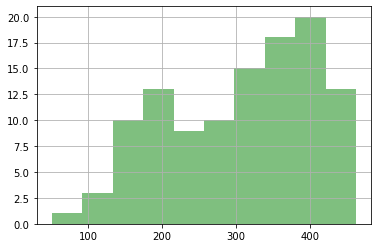

In [26]:
#ax = df_out.phi.hist(alpha=0.5)
df_out.loc[good_enough,"phi"].hist(color="g",alpha=0.5)
plt.show()

Now the payoff - using our good runs, let's make some probabilistic plots!  Here's our parameters

Gray blocks the full the range of the realizations.  These are within our bounds of reasonable given what we knew when we started, so those grey boxes represent our prior

The blue boxes show the runs that met our criteria, so that distribution represents our posterior

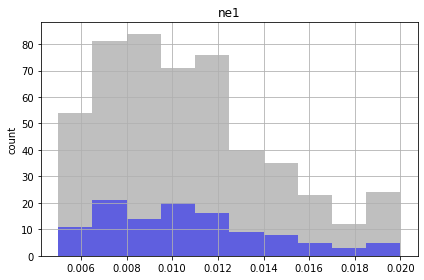

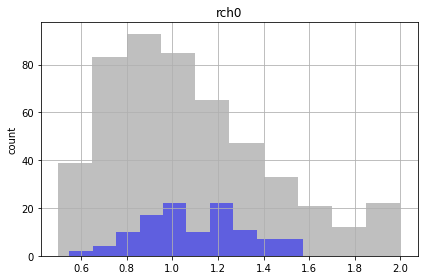

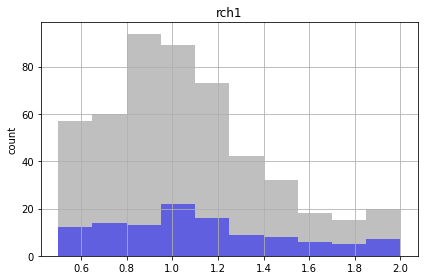

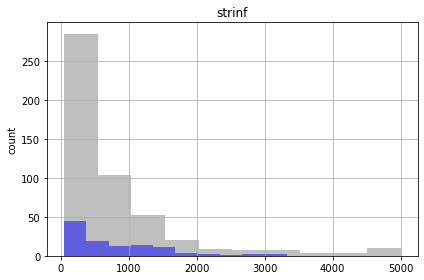

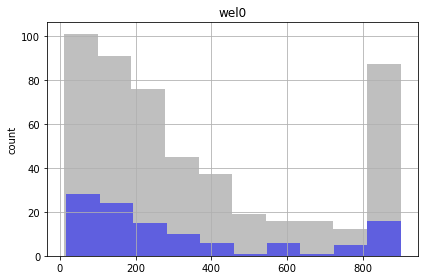

In [27]:
for parnme in pst.par_names[:5]:
    ax = plt.subplot(111)
    parensemble.loc[:,parnme].hist(bins=10,alpha=0.5,color="0.5",ax=ax,)
    parensemble.loc[good_enough,parnme].hist(bins=10,alpha=0.5,color="b",ax=ax,)   
    ax.set_title(parnme)
    plt.ylabel('count')
    plt.tight_layout()
    plt.show()

Similar to the FOSM results, the future recharge (`rch1`) and porosity (`ne1`) are not influenced by calibration. The conditioned parameter values should cover the same range as unconditioned values. 

## Let's look at the forecasts

In the plots below, prior forecast distributions are shaded grey, posteriors are graded blue and the "true" value is shown as dashed black line.

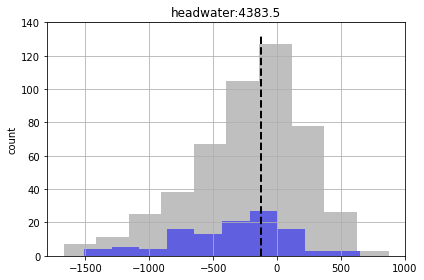

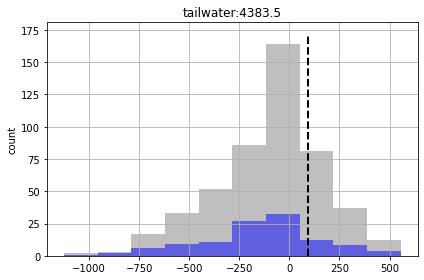

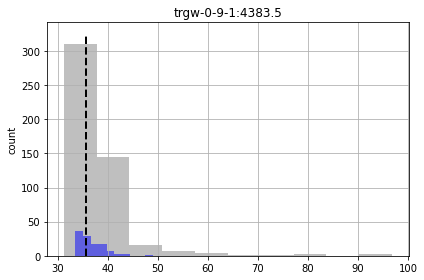

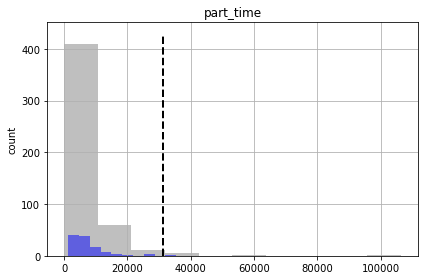

In [28]:
for forecast in pst.forecast_names:
    ax = plt.subplot(111)
    df_out.loc[:,forecast].hist(bins=10,alpha=0.5,color="0.5",ax=ax)
    df_out.loc[good_enough,forecast].hist(bins=10,alpha=0.5,color="b",ax=ax)
    v = pst.observation_data.loc[forecast,"obsval"]
    ylim = ax.get_ylim()
    ax.plot([v,v],ylim,"k--",lw=2.0)
    ax.set_ylabel('count')
    ax.set_title(forecast)
    plt.tight_layout()
    plt.show()

We see for some of the foreacsts that the prior and posterior are similar - indicating that "calibration" hasn't helped reduce forecast uncertainty. That being said, given the issues noted above for high-dimensional conditioned-MC, the very very few realisations we are using here to assess the posterior make it a bit dubious.

And, as you can see, some of the true forecast values are not being covered by the posterior. So - failing.

Its hard to say how the posterior compares to the prior with so few "good enough" realizations.  To fix this problem, we have two choices:
 - run the model more times for Monte Carlo (!)
 - generate realizations that fix the data better before hand

# Advanced Monte Carlo - sampling from the linearized posterior

In the previous section, we saw that none of the realizations fit the observations anywhere close to ``phimlim`` because of the dimensionality of the pilot point problem.  

Here, we will use some linear algebra trickeration to "pre-condition" the realizations so that they have a better chance of fitting the observations. As we all know now, "linear algebra" = Jacobian!

First we need to run the calibration process to get the calibrated parameters and last Jacobian. Let's do that quick-sticks now. The next cell repeats what we did during the "freyberg regularization" tutorial. It can take a while.

In [29]:
hbd.prep_mc(working_dir)

getting CC matrix
processing
noptmax:20, npar_adj:68, nnz_obs:37


In [30]:
pst_name = "freyberg_reg.pst"

In [31]:
m_d = 'master_amc'

In [32]:
pyemu.os_utils.start_workers(working_dir, # the folder which contains the "template" PEST dataset
                            'pestpp-glm', #the PEST software version we want to run
                            pst_name, # the control file to use with PEST
                            num_workers=num_workers, #how many agents to deploy
                            worker_root='.', #where to deploy the agent directories; relative to where python is running
                            master_dir=m_d, #the manager directory
                            )



             pestpp-glm: a tool for GLM parameter estimation and FOSM uncertainty analysis

                                   by The PEST++ Development Team


version: 5.1.17
binary compiled on Jun 10 2022 at 13:10:45

started at 08/26/22 11:23:00
...processing command line: ' ./pestpp-glm freyberg_reg.pst /h :4004'
...using panther run manager in master mode using port 4004

using control file: "freyberg_reg.pst"

in directory: "/Users/mnfienen/Documents/GIT/GMDSI_notebooks/tutorials/part1_12_monte_carlo/master_amc"
on host: "IGSARMEWLTMNFI"

processing control file freyberg_reg.pst
Note: 3 unused lines in pest control file, see rec file...


:~-._                                                 _.-~:
: :.~^o._        ________---------________        _.o^~.:.:
 : ::.`?88booo~~~.::::::::...::::::::::::..~~oood88P'.::.:
 :  ::: `?88P .:::....         ........:::::. ?88P' :::. :
  :  :::. `? .::.            . ...........:::. P' .:::. :
   :  :::   ... ..  ...       .. .::::......::.  

08/26 11:25:22 avg:0.12  runs(C10   |F0    |T0    ) agents(R0   |W10  |U0   ) 0  

   10 runs complete :  0 runs failed
   0.121 avg run time (min) : 0.172 run mgr time (min)
   10 agents connected


  testing upgrade vectors... 

  ...Lambda testing complete for iteration 2
    starting phi = 65;  ending phi = 55  (84% of starting phi)


OPTIMISATION ITERATION NUMBER: 3

  Iteration type: base parameter solution
  SVD Package: RedSVD
  Model calls so far : 157

  calculating jacobian...     running model 68 times
    starting at 08/26/22 11:25:22
    10 agents ready


PANTHER progress
   avg = average model run time in minutes
   runs(C = completed | F = failed | T = timed out)
   agents(R = running | W = waiting | U = unavailable)
---------------------------------------------------------------------------------
08/26 11:26:15 avg:0.12  runs(C68   |F0    |T0    ) agents(R0   |W10  |U0   ) 0  

   68 runs complete :  0 runs failed
   0.116 avg run time (min) : 0.889 run mgr time (min)


    ...solving for optimal weight factor : 6.7   
    ...solving for optimal weight factor : 8.7   
    ...solving for optimal weight factor : 11    
    ...solving for optimal weight factor : 15    
    ...solving for optimal weight factor : 19    
    ...solving for optimal weight factor : 25    
    ...solving for optimal weight factor : 32    
    ...solving for optimal weight factor : 42    
    ...solving for optimal weight factor : 54    
    ---  optimal regularization weight factor found  ---   
      updated regularization  weight factor            : 54.471
      FRACPHIM adjusted measurement objective function : 24.1493
      discrepancy                                      : 67.4%

  computing upgrade vector (lambda = 0.1)  1 / 5             
  computing upgrade vector (lambda = 1)  2 / 5             
  computing upgrade vector (lambda = 10)  3 / 5             
  computing upgrade vector (lambda = 100)  4 / 5             
  computing upgrade vector (lambda = 1000)  5 / 5   

In [33]:
pst = pyemu.Pst(os.path.join(m_d, pst_name))

###  ```schur``` bayesian monte carlo

Here, we will swap out the prior parameter covariance matrix ($\boldsymbol{\Sigma}_{\theta}$) for the FOSM-based posterior parameter covariance matrix ($\overline{\boldsymbol{\Sigma}}_{\theta}$).  Everything else is exactly the same (sounds like a NIN song)

In [34]:
sc = pyemu.Schur(jco=os.path.join(m_d,pst_name.replace(".pst",".jcb")),
                pst=pst,
                parcov=cov) # geostatistically informed covariance matrix we built earlier

Update the control file with the "best fit" parameters (e.g. the calibrated parameters). These values are the mean ofthe posterior parameter probability distribution.

In [35]:
sc.pst.parrep(os.path.join(m_d,pst_name.replace(".pst",".parb")))

parrep: updating noptmax to 0


In [36]:
parensemble = pyemu.ParameterEnsemble.from_gaussian_draw(pst=sc.pst,
                                                        cov=sc.posterior_parameter, # posterior parameter covariance
                                                        num_reals=500,)

drawing from group hk1
drawing from group porosity
drawing from group rch0
drawing from group rch1
drawing from group rchpp
drawing from group strinf
drawing from group wel


In [37]:
parensemble.to_csv(os.path.join(working_dir,"sweep_in.csv"))

In [38]:
pyemu.os_utils.start_workers(working_dir, # the folder which contains the "template" PEST dataset
                            'pestpp-swp', #the PEST software version we want to run
                            pst_name, # the control file to use with PEST
                            num_workers=num_workers, #how many agents to deploy
                            worker_root='.', #where to deploy the agent directories; relative to where python is running
                            master_dir=m_d, #the manager directory
                            )



             pestpp-swp - a parameteric sweep utility, version 5.1.17
                     for PEST(++) datasets 

                 by the PEST++ development team


...processing command line: ' ./pestpp-swp freyberg_reg.pst /h :4004'
...using panther run manager in master mode using port 4004



version: 5.1.17
binary compiled on Jun 10 2022 at 13:10:45

started at 08/26/22 11:30:25
using control file: "freyberg_reg.pst"

in directory: "/Users/mnfienen/Documents/GIT/GMDSI_notebooks/tutorials/part1_12_monte_carlo/master_amc"
on host: "IGSARMEWLTMNFI"

processing control file freyberg_reg.pst
Note: 3 unused lines in pest control file, see rec file...
pest++ arg SWEEP_PARAMETER_CSV_FILE not set, using 'SWEEP_IN.CSV'


:~-._                                                 _.-~:
: :.~^o._        ________---------________        _.o^~.:.:
 : ::.`?88booo~~~.::::::::...::::::::::::..~~oood88P'.::.:
 :  ::: `?88P .:::....         ........:::::. ?88P' :::. :
  :  :::. `? .::.            . ...

In [39]:
df_out = pd.read_csv(os.path.join(m_d,"sweep_out.csv"),index_col=0)
df_out = df_out.loc[df_out.failed_flag==0,:] #drop any failed runs
#df_out = df_out.loc[~df_out.le(-2.e27).any(axis=1)] #drop extreme values
df_out.columns = [c.lower() for c in df_out.columns]
df_out.head()

,input_run_id,failed_flag,phi,meas_phi,regul_phi,gage-1,headwater,particle,tailwater,trgw-0-13-10,...,trgw-0-9-1:4108.5,trgw-0-9-1:4138.5,trgw-0-9-1:4169.5,trgw-0-9-1:4199.5,trgw-0-9-1:4230.5,trgw-0-9-1:4261.5,trgw-0-9-1:4291.5,trgw-0-9-1:4322.5,trgw-0-9-1:4352.5,trgw-0-9-1:4383.5
run_id,,,,,,,,,,,,,,,,,,,,,
0,0,0,1.79769313486232e+308,350.229251,1.79769313486232e+308,296.223964,0.0,0.0,0.0,0.0,...,41.606871,41.786234,41.963629,41.994475,41.864626,41.660883,41.410192,41.146770,40.942257,40.872751
1,1,0,1.79769313486232e+308,737.037478,1.79769313486232e+308,618.189928,0.0,0.0,0.0,0.0,...,34.991161,35.144349,35.248434,35.256780,35.155018,34.962972,34.731933,34.504093,34.347468,34.334178
2,2,0,1.79769313486232e+308,2047.069815,1.79769313486232e+308,1854.307783,0.0,0.0,0.0,0.0,...,37.274435,37.377738,37.448185,37.443558,37.345305,37.164853,36.943253,36.714026,36.540306,36.489311
3,3,0,1.79769313486232e+308,2517.832376,1.79769313486232e+308,2288.894713,0.0,0.0,0.0,0.0,...,35.359350,35.443708,35.505361,35.504137,35.421610,35.267037,35.077549,34.886018,34.750331,34.735964
4,4,0,1.79769313486232e+308,459.882110,1.79769313486232e+308,362.900574,0.0,0.0,0.0,0.0,...,39.045140,39.220666,39.355018,39.400471,39.341382,39.188885,38.985965,38.769918,38.605667,38.564030


In [40]:
df_out.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 487 entries, 0 to 499
Columns: 431 entries, input_run_id to trgw-0-9-1:4383.5
dtypes: float64(426), int64(2), object(3)
memory usage: 1.6+ MB


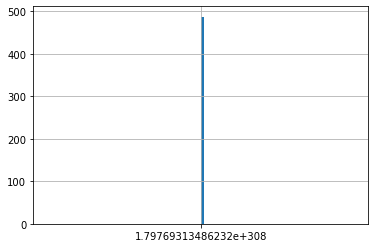

In [41]:
df_out.phi.hist(bins=100);

Now we see, using the same Phi threshold we obtain a larger number of "good enough" parameter sets:

In [42]:
good_enough = df_out.loc[df_out.meas_phi<acceptable_phi].index.values
print("number of good enough realisations:", good_enough.shape[0])

number of good enough realisations: 178


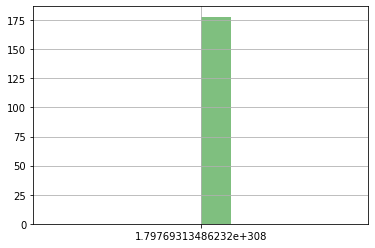

In [43]:
#ax = df_out.phi.hist(alpha=0.5)
df_out.loc[good_enough,"phi"].hist(color="g",alpha=0.5)
plt.show()

However, even so we are failing to entirely capture the truth values of all forecasts (see "part_time" forecast). So our forecast posterior is overly narrow (non-conservative). 

Why? Because our uncertainty analysis is __not robust__ for all our forecasts, even with non-linear Monte Carlo. The parameterization scheme is still too coarse. ...segway to high-dimension PEST setup in PART2.

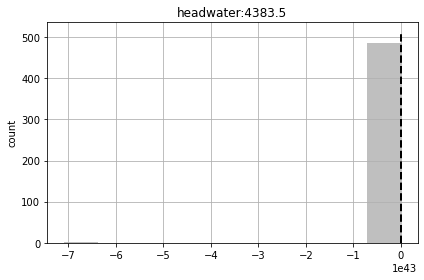

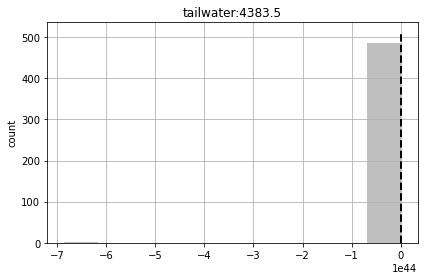

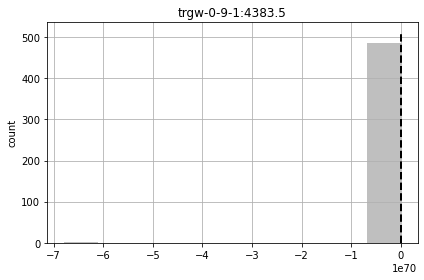

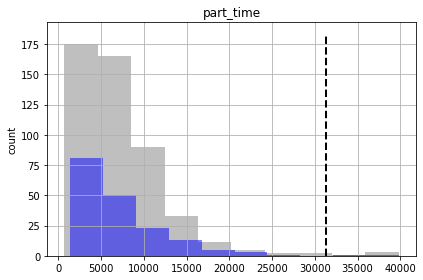

In [44]:
for forecast in pst.forecast_names:
    ax = plt.subplot(111)
    df_out.loc[:,forecast].hist(bins=10,alpha=0.5,color="0.5",ax=ax)
    df_out.loc[good_enough,forecast].hist(bins=10,alpha=0.5,color="b",ax=ax)
    v = pst.observation_data.loc[forecast,"obsval"]
    ylim = ax.get_ylim()
    ax.plot([v,v],ylim,"k--",lw=2.0)
    ax.set_ylabel('count')
    ax.set_title(forecast)
    plt.tight_layout()
    plt.show()